Feature Regressions using Machine Learning (ML) & Deep Learning (DL) Algorithms

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, LassoCV, SGDRegressor, ElasticNetCV
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [4]:
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [5]:
fovs = ['A2_1', 'A2_2', 'A2_3', 'B2_1', 'B2_3', 'B2_4']
nfovs = len(fovs)
pathSet = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/'
modelList = [None]*(nfovs)
modelList_conditions = np.zeros(nfovs).astype(int)

In [6]:
for i in range(nfovs):
    modelList_conditions[i] = i
    modelList[i] = f"{pathSet}{sysName}_{fovs[i]}"
    #print("Model Info: ",modelList[i])

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [7]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models, i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_3.obj with 58579 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_1.obj with 67836 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_3.obj with 57884 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_4.obj with 46096 cells


In [8]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [9]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [10]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
for i in indgood_models:
    modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0

In [11]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [12]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])

for i in indgood_models:
    Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
    # Indices for each model for later access using them
    indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
    indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [13]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf = Xf[indsf, :]

In [14]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell

In [15]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory 
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

Single-cell Trajectories Over The Cell Features

In [16]:
trajl = 1
Xf_traj = np.zeros((0, n_features*trajl + n_COMfeatures*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf[modelSet[i].traj, :] 
    datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf.shape[1]*trajl)
    datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Building trajectory data for model: 0
Building trajectory data for model: 1
Building trajectory data for model: 2
Building trajectory data for model: 3
Building trajectory data for model: 4
Building trajectory data for model: 5


In [17]:
# Get Cross correlations & respective frame numbers along all single-cell trajectories
def get_cross_corr_all_single_cell_trajs(filename):
      cross_corr_sctraj = []
      frame_num_sctraj = []
      with open(filename, 'r') as file_in:
          # Create an iterator over the file lines 
          file_iter = iter(file_in)
          try:
              while True:
                  # Read two lines at a time: Cross correlations & the corresponding frame numbers
                  line1 = next(file_iter).strip()
                  if line1:
                          data = ast.literal_eval(line1)
                          cross_corr_sctraj.append(data)
                          line2 = next(file_iter).strip()
                          # Parse line2 as a list of integers
                          frame_numbers = ast.literal_eval(line2)   
                          frame_num_sctraj.append(frame_numbers)
          except StopIteration:
              # End of file reached
              pass
      cross_corr_all_sctraj_file = cross_corr_sctraj
      frame_num_all_sctraj_file = frame_num_sctraj
      
      return cross_corr_all_sctraj_file, frame_num_all_sctraj_file

In [18]:
cc_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/dcompCCtraj_states/'

In [19]:
X = [None] * nfovs
y = [None] * nfovs

for i in range(nfovs):
    # Get cross-correlation values along all single-cell trajectories  
    cc_filename = f"{cc_path}{sysName}_{fovs[i]}.dat"
    cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

    cc_values_last_frames = []
    model_indc = i
    indstm = np.where(indtreatment_traj == model_indc)[0]
    fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
    indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
    ################## Identify the "FULL" trajectory index and locate snippets within it ##################
    for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
        possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])  
        indc_ccvals_traj = possible_indices[0][0]
        #print(f'Indices of Entire Traj: {ind_fulltraj}, Indices of CC_traj: {indc_ccvals_traj}')
        cc_vals = cross_correlations[ind_fulltraj][indc_ccvals_traj]
        #print(f'CC values: {cc_vals}, Indices of Entire Traj: {ind_fulltraj}, Indices of CC trajectory: {indc_ccvals_traj}')
        cc_values_last_frames.append(cc_vals)
    cc_values_last_frames = np.array(cc_values_last_frames)
    X_traj_model = Xf_traj[indstm]
    X[i] = X_traj_model
    y[i] = cc_values_last_frames

Leaving One (FOV) Out Cross Validations

In [20]:
model_linRegFOV = LinearRegression(n_jobs=-1)

In [21]:
# Linear Regressor with Stochastic Gradient Descent 
model_lrSGD = SGDRegressor(max_iter=10000, tol=1e-4, learning_rate='invscaling', eta0=0.01)

In [22]:
def trim_cc_vals(cc_values, num_bins, target_density):
    df = pd.DataFrame(cc_values, columns=['CC'])
    df['original_index'] = df.index # Include original indices in the DataFrame
    
    counts, bin_edges = np.histogram(df['CC'], bins=num_bins) # Calculate histogram without plotting
    df['bin'] = pd.cut(df['CC'], bins=bin_edges, labels=False, include_lowest=True) # Create a bin label based on the bin_edges

    trimmed_data = []
    
    for i in range(num_bins):
        bin_filter = (df['bin'] == i) # Filter the DataFrame to get data only in this bin
        bin_data = df[bin_filter]

        # If the number of items in the bin is greater than target_density, sample down
        if bin_data.shape[0] > target_density:
           sampled_data = bin_data.sample(n=target_density, random_state=42)
        else:
           sampled_data = bin_data
        trimmed_data.append(sampled_data) # Append the sampled or full bin data to the list
    
    trimmed_df = pd.concat(trimmed_data) # Concatenate all trimmed data back into a DataFrame
    trimmed_df = trimmed_df.sort_values('original_index') # Sorting by original index to preserve the original data order
    
    return trimmed_df

In [25]:
def unique_predictive_features(n_top_cont_features = 5):
    loadings = pca.components_
    feature_inds = np.array([]).astype(int)
    for i, pc in enumerate(loadings):
        # Gets indices of the top features for each PC
        top_features_indices = np.argsort(np.abs(pc))[-n_top_cont_features:] 
        #print(f"Top {n_cf} contributing feature indices for PC{i+1}: {top_features_indices}")
        feature_inds = np.append(feature_inds, top_features_indices)
    unique_feature_inds = np.unique(feature_inds)

    return unique_feature_inds

In [26]:
# Get an initial set of alpha values from the first run that's the best predictor
init_alphas = np.array([0.24564907, 0.22909314, 0.21365303, 0.19925353, 0.18582451, 0.17330056,
                        0.16162068, 0.15072799, 0.14056943, 0.13109552, 0.12226012, 0.1140202, 
                        0.10633562, 0.09916895, 0.0924853, 0.0862521, 0.08043899, 0.07501768, 
                        0.06996174, 0.06524655, 0.06084915, 0.05674812, 0.05292349, 0.04935662,
                        0.04603015, 0.04292787, 0.04003468, 0.03733647, 0.03482012, 0.03247336, 
                        0.03028477, 0.02824367, 0.02634014, 0.02456491, 0.02290931, 0.0213653,
                        0.01992535, 0.01858245, 0.01733006, 0.01616207, 0.0150728, 0.01405694,
                        0.01310955, 0.01222601, 0.01140202, 0.01063356, 0.0099169, 0.00924853,
                        0.00862521, 0.0080439, 0.00750177, 0.00699617, 0.00652465, 0.00608491,
                        0.00567481, 0.00529235, 0.00493566, 0.00460302, 0.00429279, 0.00400347,
                        0.00373365, 0.00348201, 0.00324734, 0.00302848, 0.00282437, 0.00263401,
                        0.00245649, 0.00229093, 0.00213653, 0.00199254, 0.00185825, 0.00173301,
                        0.00161621, 0.00150728, 0.00140569, 0.00131096, 0.0012226, 0.0011402,
                        0.00106336, 0.00099169, 0.00092485, 0.00086252, 0.00080439, 0.00075018,
                        0.00069962, 0.00065247, 0.00060849, 0.00056748, 0.00052923, 0.00049357,
                        0.0004603, 0.00042928, 0.00040035, 0.00037336, 0.0003482, 0.00032473,
                        0.00030285, 0.00028244, 0.0002634, 0.00024565])

In [27]:
# Get an initial set of alpha values from the first run that's the best predictor
init_alphas = np.array([0.6321968, 0.4567035, 0.24564907, 0.22909314, 0.21365303, 0.19925353,
                        0.18582451, 0.17330056, 0.16162068, 0.15072799, 0.14056943, 0.0004603,
                        0.00042928, 0.00040035, 0.00037336, 0.0003482, 0.00032473, 0.00030285,
                        0.00028244, 0.0002634, 0.00024565])

In [34]:
fovs_indc = [i for i in range(nfovs)]
fovs_indc = np.array(fovs_indc)
fovs_inds_test = np.array([3, 4, 5])
fovs_inds_train = np.setdiff1d(fovs_indc, fovs_inds_test)

Indices of Non-Zero PCs/Features Selected by CV model: [ 1  2  3  4  8  9 11 13 15 17 19 22]
Indices of Non-Zero PCs/Features Selected by CV model: [ 1  2  3  4  8  9 11 13 15 17 19 22]
Indices of Non-Zero PCs/Features Selected by CV model: [ 1  2  3  4  8  9 11 13 15 17 19 22]
Indices of Non-Zero PCs/Features Selected by CV model: [ 1  2  3  4  8  9 11 13 15 17 19 22]


<Figure size 640x480 with 0 Axes>

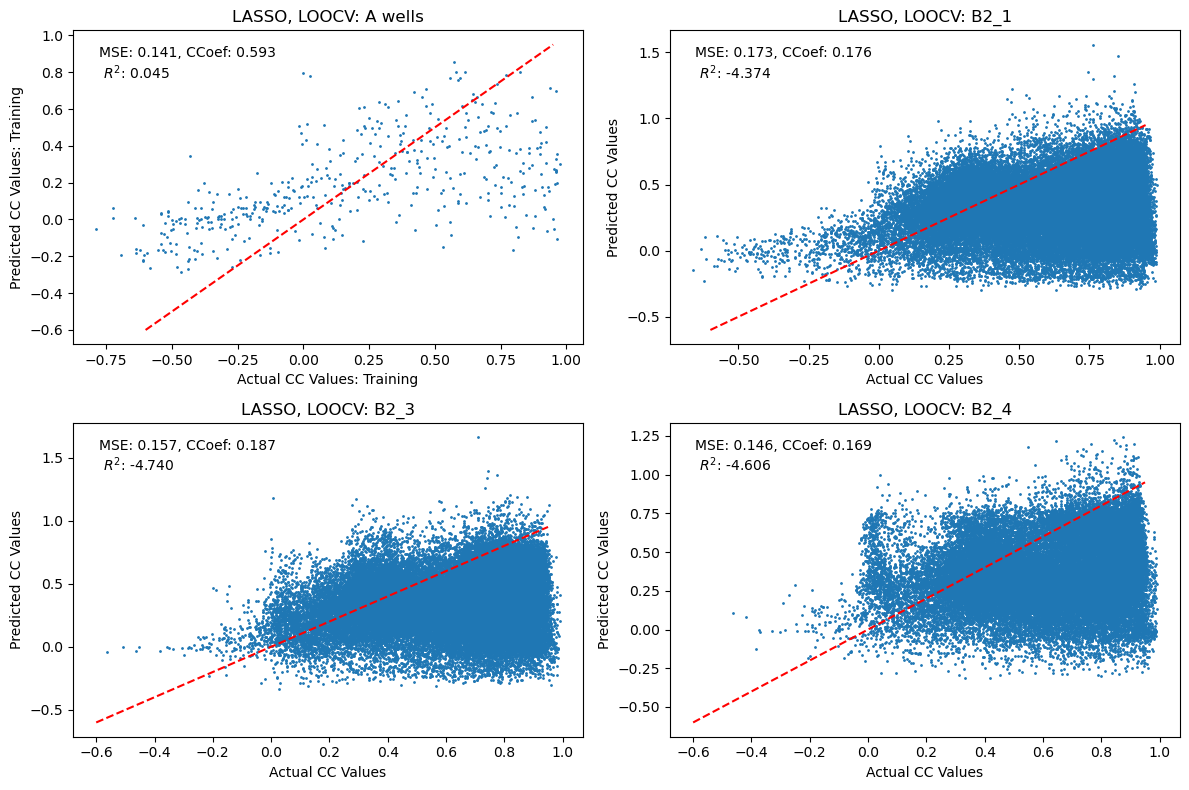

In [39]:
# Training on 'A' wells & Testing on 'B' wells using LASSOCV directly on original features
fname = f'lassoTrainTrimTestFullDataAllFeatBwells_tRgTrajl{trajl}'
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()

train_fovs = fovs_inds_train
X_train = np.zeros((0, X[0].shape[1]))
y_train = np.zeros(0)
for it_fov in train_fovs:
    X_train = np.append(X_train, X[it_fov], axis = 0)
    y_train = np.append(y_train, y[it_fov], axis = 0)
############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]
    
indc_predictive_features = np.array([14, 42, 45, 50, 53, 56, 57, 58, 59, 61, 65, 67, 68,
                                     77, 78, 79, 80, 81, 84, 87, 89, 91, 92, 94]).astype(int)
X_train_trim = X_train_trim[:, indc_predictive_features]

# Least Absolute Shrinkage and Selection Operator (LASSO)
pipe = Pipeline([
                ('scaler', StandardScaler()), 
                ('elasticnet_cv', ElasticNetCV(cv=5, alphas=init_alphas, max_iter=1000000, random_state=0,
                                                l1_ratio=[.1, .5, .7, .9, .95, 1], n_jobs=-1))
                #('lassocv', LassoCV(cv=5,max_iter=1000000,n_alphas=50,tol=1e-6,selection='random',n_jobs=-1))
                ])
pipe.fit(X_train_trim, y_train_trim)
#model = pipe.named_steps['lassocv'] # Access the fitted LassoCV from the pipeline
model = pipe.named_steps['elasticnet_cv'] # Access the fitted ElasticNetCV from the pipeline

y_pred_lasso_train = pipe.predict(X_train_trim)
mse = mean_squared_error(y_train_trim, y_pred_lasso_train)
correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
score = model.score(X_train_trim, y_train_trim)
axs[0].scatter(y_train_trim, y_pred_lasso_train, s = 1)
axs[0].set_xlabel('Actual CC Values: Training')
axs[0].set_ylabel('Predicted CC Values: Training')

################# Which features are considered "important" LOOCV Linear Regression #################
coefficients = model.coef_
non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
#print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
corr_coeff = correlation_matrix[0, 1]
axs[0].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
axs[0].set_title('LASSO, LOOCV: A wells')
axs[0].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}\n $R^2$: {score:.3f}', 
            transform=axs[0].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')

data_list = []
data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
data_list.append(data)

for i, fov in enumerate(fovs_inds_test):
    test_fov = fov
    
    X_test = X[test_fov]
    y_test = y[test_fov]
    
    X_test = X_test[:, indc_predictive_features]
    
    y_pred_lasso = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    score = model.score(X_test, y_test)
    axs[i+1].scatter(y_test, y_pred_lasso, s = 1)
    axs[i+1].set_xlabel('Actual CC Values')
    axs[i+1].set_ylabel('Predicted CC Values')
    
    ################# Which features are considered "important" LOOCV Linear Regression #################
    coefficients = model.coef_
    non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
    print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
    #print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
    corr_coeff = correlation_matrix[0, 1]
    axs[i+1].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[i+1].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    axs[i+1].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}\n $R^2$: {score:.3f}', 
                  transform=axs[i+1].transAxes, 
                  verticalalignment='top',
                  horizontalalignment='left')
    data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
    data_list.append(data)
with open(f'{fname}.json', 'w') as fout:
    json.dump(data_list, fout, indent=4)
plt.tight_layout()
#plt.show()
plt.savefig(f'{fname}.png', dpi = 400, bbox_inches='tight')

Indices of Non-Zero PCs/Features Selected by CV model: [0 1 3 5 6 7 8 9]
Indices of Non-Zero PCs/Features Selected by CV model: [0 1 3 5 6 7 8 9]
Indices of Non-Zero PCs/Features Selected by CV model: [0 1 3 5 6 7 8 9]
Indices of Non-Zero PCs/Features Selected by CV model: [0 1 3 5 6 7 8 9]


<Figure size 640x480 with 0 Axes>

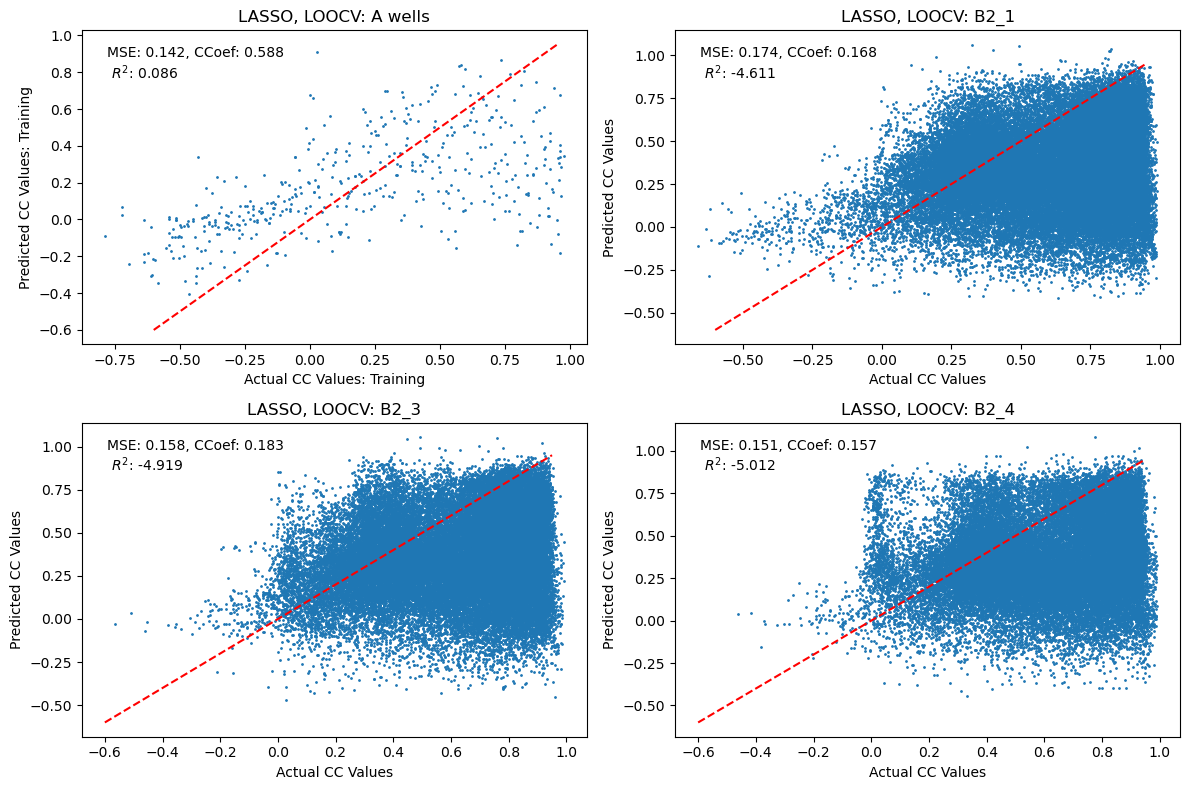

In [45]:
# Training on 'A' wells & Testing on 'B' wells using LASSOCV 
fname = f'lassoTrainTrimTestFullDataAllFeatBwells_trajl{trajl}'
target_density = 10; n_bins = 50

plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()

train_fovs = fovs_inds_train
X_train = np.zeros((0, X[0].shape[1]))
y_train = np.zeros(0)
for it_fov in train_fovs:
    X_train = np.append(X_train, X[it_fov], axis = 0)
    y_train = np.append(y_train, y[it_fov], axis = 0)
############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]
############### Dimensional reduction on trimmed training data ###############
indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
Xpca_train_trim = X_train_trim[:, indc_predictive_features]
    
# Least Absolute Shrinkage and Selection Operator (LASSO)
pipe = Pipeline([
                ('scaler', StandardScaler()), 
                #('elasticnet_cv', ElasticNetCV(cv=5, alphas=init_alphas, max_iter=1000000, random_state=0,
                                               #l1_ratio=[.1, .5, .7, .9, .95, 1], n_jobs=-1))
                ('lassocv', LassoCV(cv=5,max_iter=1000000,tol=1e-4,selection='random',n_jobs=-1))
                ])
pipe.fit(Xpca_train_trim, y_train_trim)
model = pipe.named_steps['lassocv'] # Access the fitted LassoCV from the pipeline
#model = pipe.named_steps['elasticnet_cv'] # Access the fitted ElasticNetCV from the pipeline

y_pred_lasso_train = pipe.predict(Xpca_train_trim)
mse = mean_squared_error(y_train_trim, y_pred_lasso_train)
correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
score = model.score(Xpca_train_trim, y_train_trim)
axs[0].scatter(y_train_trim, y_pred_lasso_train, s = 1)
axs[0].set_xlabel('Actual CC Values: Training')
axs[0].set_ylabel('Predicted CC Values: Training')

################# Which features are considered "important" LOOCV Linear Regression #################
coefficients = model.coef_
non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
#print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
corr_coeff = correlation_matrix[0, 1]
axs[0].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
axs[0].set_title('LASSO, LOOCV: A wells')
axs[0].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}\n $R^2$: {score:.3f}', 
            transform=axs[0].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')

data_list = []
data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
data_list.append(data)

for i, fov in enumerate(fovs_inds_test):
    test_fov = fov
    X_test = X[test_fov]
    y_test = y[test_fov]
    Xpca_test = X_test[:, indc_predictive_features]
    
    y_pred_lasso = pipe.predict(Xpca_test)
    mse = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    score = model.score(Xpca_test, y_test)
    axs[i+1].scatter(y_test, y_pred_lasso, s = 1)
    axs[i+1].set_xlabel('Actual CC Values')
    axs[i+1].set_ylabel('Predicted CC Values')
    
    ################# Which features are considered "important" LOOCV Linear Regression #################
    coefficients = model.coef_
    non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
    print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
    #print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
    corr_coeff = correlation_matrix[0, 1]
    axs[i+1].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[i+1].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    axs[i+1].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}\n $R^2$: {score:.3f}', 
                  transform=axs[i+1].transAxes, 
                  verticalalignment='top',
                  horizontalalignment='left')
    data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
    data_list.append(data)
with open(f'{fname}.json', 'w') as fout:
    json.dump(data_list, fout, indent=4)
plt.tight_layout()
#plt.show()
plt.savefig(f'{fname}.png', dpi = 400, bbox_inches='tight')

In [23]:
fovs_indc = [i for i in range(nfovs)]
fovs_indc = np.array(fovs_indc)
exclude_fovs = np.array([3, 4])
exclude_cond = True #exclude_cond = False
if exclude_cond:
    fovs_indc = np.delete(fovs_indc, exclude_fovs)
    print(f'Final Field of Views to be analyzed: {fovs_indc}')
else: 
    print(f'Final Field of Views to be analyzed: {fovs_indc}')

Final Field of Views to be analyzed: [0 1 2 5]


In [ ]:
############## Training & Testing using LASSOCV directly on original features ##############
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############################ Trim Training Data ############################ 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for it in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    
    indc_predictive_features = np.array([14, 42, 45, 50, 53, 56, 57, 58, 59, 61, 65, 67, 68,
    77, 78, 79, 80, 81, 84, 87, 89, 91, 92, 94]).astype(int)
    print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
    X_train_trim = X_train_trim[:, indc_predictive_features]
    X_test = X_test[:, indc_predictive_features]
    
    # Least Absolute Shrinkage and Selection Operator (LASSO)
    pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('elasticnet_cv', ElasticNetCV(cv=5, alphas=init_alphas, max_iter=1000000, random_state=0,
                                                   l1_ratio=[.1, .5, .7, .9, .95, 1], n_jobs=-1))
                    #('lassocv', LassoCV(cv=5,max_iter=1000000,n_alphas=50,tol=1e-6,selection='random',n_jobs=-1))
                    ])
    pipe.fit(X_train_trim, y_train_trim)
    #model = pipe.named_steps['lassocv'] # Access the fitted LassoCV from the pipeline
    model = pipe.named_steps['elasticnet_cv'] # Access the fitted ElasticNetCV from the pipeline
    test_perform = True 
    if test_perform:
        y_pred_lasso = pipe.predict(X_test)
        mse = mean_squared_error(y_test, y_pred_lasso)
        correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
        score = model.score(X_test, y_test)
        axs[i].scatter(y_test, y_pred_lasso, s = 1)
        axs[i].set_xlabel('Actual CC Values')
        axs[i].set_ylabel('Predicted CC Values')
    else:
        y_pred_lasso_train = pipe.predict(X_train_trim)
        mse = mean_squared_error(y_train_trim, y_pred_lasso_train)
        correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
        score = model.score(X_train_trim, y_train_trim)
        axs[i].scatter(y_train_trim, y_pred_lasso_train, s = 1)
        axs[i].set_xlabel('Actual CC Values: Training')
        axs[i].set_ylabel('Predicted CC Values: Training')
    
    ################# Which features are considered "important" LOOCV Linear Regression #################
    coefficients = model.coef_
    non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
    print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
    #print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
    corr_coeff = correlation_matrix[0, 1]
    axs[i].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[i].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    axs[i].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}\n $R^2$: {score:.3f}', 
                transform=axs[i].transAxes, 
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
plt.show()
#plt.savefig(f'lassoTrainTrimTestTrainDataAllFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
#plt.savefig(f'lassoTrainTrimTestFullDataAllFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')

In [ ]:
# Simple Linear Regression & Linear Regression with Stochastic Gradient Descent (SGD) 
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############################ Trim Training Data ############################ 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for it in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    
    dim_reduction = False
    if dim_reduction:
        ############### Dimensional reduction on trimmed training data ###############
        pca.fit(X_train_trim) 
        Xpca_train_trim = pca.transform(X_train_trim)
        Xpca_test = pca.transform(X_test)
    else: 
        # Select features accroding to their predictive performance 
        top_contFeat_pc = 2 # Number of top contributing features in each PC
        #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
        indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
        print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
        Xpca_train_trim = X_train_trim[:, indc_predictive_features]
        Xpca_test = X_test[:, indc_predictive_features]
    
    #model_linRegFOV.fit(Xpca_train_trim, y_train)
    model_lrSGD.fit(Xpca_train_trim, y_train) # Linear Regression with Stochastic Gradient Descent
    # Predict on the test set: Linear Regression
    #y_pred_linRegLOFO = model_linRegFOV.predict(Xpca_test)
    
    y_pred_linRegLOFO = model_lrSGD.predict(Xpca_test) # Linear Regression with Stochastic Gradient Descent
    mse_test = mean_squared_error(y_test, y_pred_linRegLOFO)
    correlation_matrix = np.corrcoef(y_test, y_pred_linRegLOFO)
    """
    # Predict on the training set
    #y_pred_linRegLOFO_train = model_linRegFOV.predict(Xpca_train_trim) # Simple Linear Regression
    y_pred_linRegLOFO_train = model_lrSGD.predict(Xpca_train_trim) # Linear Regression with Stochastic Gradient Descent
    mse_train = mean_squared_error(y_train, y_pred_linRegLOFO_train)
    correlation_matrix = np.corrcoef(y_train, y_pred_linRegLOFO_train)
    """
    corr_coeff = correlation_matrix[0, 1]
    axs[i].scatter(y_test, y_pred_linRegLOFO, s = 1)
    #axs[i].scatter(y_train, y_pred_linRegLOFO_train, s = 1)
    axs[i].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[i].set_xlabel('Actual CC Values')
    axs[i].set_ylabel('Predicted CC Values')
    #axs[i].set_xlabel('Actual CC Values: Training')
    #axs[i].set_ylabel('Predicted CC Values: Training')
    axs[i].set_title(f'Linear Regression, LOOCV: {fovs[fov]}')
    #axs[i].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}',
    axs[i].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}',
                transform=axs[i].transAxes,
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
#plt.show()
plt.savefig(f'linRegTest4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
#plt.savefig(f'linRegTrain4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')

In [ ]:
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############################ Trim Training Data ############################ 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for it in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    dim_reduction = False
    if dim_reduction:
        ############### Dimensional reduction on trimmed training data ###############
        pca.fit(X_train_trim) 
        Xpca_train_trim = pca.transform(X_train_trim)
        Xpca_test = pca.transform(X_test)
    else: 
        # Select features accroding to their predictive performance 
        top_contFeat_pc = 2 # Number of top contributing features in each PC
        #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
        indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
        print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
        Xpca_train_trim = X_train_trim[:, indc_predictive_features]
        Xpca_test = X_test[:, indc_predictive_features]
    
    # Least Absolute Shrinkage and Selection Operator (LASSO)
    pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('lassocv', LassoCV(cv=100, max_iter=100000, tol=1e-5, selection='random', n_jobs=-1))
                    ])
    pipe.fit(Xpca_train_trim, y_train_trim)
    """
    y_pred_lasso = pipe.predict(Xpca_test)
    mse_test = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    """
    y_pred_lasso_train = pipe.predict(Xpca_train_trim)
    mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train)
    correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
    
    ################### Which features are considered "important" by LASSO ###################
    coefficients = pipe.named_steps['lassocv'].coef_
    # Identify non-zero coefficients (features to keep)
    non_zero_indices = np.where(coefficients != 0)[0]
    print(f"Indices of Non-Zero PCs/Features Selected by LassoCV: {non_zero_indices}")
    corr_coeff = correlation_matrix[0, 1]
    #axs[i].scatter(y_test, y_pred_lasso, s = 1)
    axs[i].scatter(y_train_trim, y_pred_lasso_train, s = 1)
    axs[i].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    #axs[i].set_xlabel('Actual CC Values')
    #axs[i].set_ylabel('Predicted CC Values')
    axs[i].set_xlabel('Actual CC Values: Training')
    axs[i].set_ylabel('Predicted CC Values: Training')
    axs[i].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    axs[i].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}',
    #axs[i].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}', 
                transform=axs[i].transAxes, 
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
#plt.show()
plt.savefig(f'lassoTrainTrimTestTrainDataSupFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
#plt.savefig(f'lassoTrainTrimTestFullDataSupFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')

Indices of top predictive features from LASSOCV on snapshots: [25 31 36 42 43 55 62 77 78 92 93 94]

In [ ]:
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############## Trim Training Data ############## 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for it in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    dim_reduction = False
    if dim_reduction:
        ############### Dimensional reduction on trimmed training data ###############
        pca.fit(X_train_trim) 
        Xpca_train_trim = pca.transform(X_train_trim)
        Xpca_test = pca.transform(X_test)
    else: 
        # Select features accroding to their predictive performance 
        top_contFeat_pc = 2 # Number of top contributing features in each PC
        #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
        indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
        print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
        Xpca_train_trim = X_train_trim[:, indc_predictive_features]
        Xpca_test = X_test[:, indc_predictive_features]
    
    # Least Absolute Shrinkage and Selection Operator (LASSO)
    pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('lassocv', LassoCV(cv=100, max_iter=100000, tol=1e-5, selection='random', n_jobs=-1))
                    ])
    pipe.fit(Xpca_train_trim, y_train_trim)
    
    y_pred_lasso = pipe.predict(Xpca_test)
    mse_test = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    """
    y_pred_lasso_train = pipe.predict(Xpca_train_trim)
    mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train)
    correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
    """
    ################### Which features are considered "important" by LASSO ###################
    coefficients = pipe.named_steps['lassocv'].coef_
    # Identify non-zero coefficients (features to keep)
    non_zero_indices = np.where(coefficients != 0)[0]
    print(f"Indices of Non-Zero PCs/Features Selected by LassoCV: {non_zero_indices}")
    
    corr_coeff = correlation_matrix[0, 1]
    xy = np.vstack([y_test, y_pred_lasso])
    #xy = np.vstack([y_train_trim, y_pred_lasso_train])
    z = scipy.stats.gaussian_kde(xy)(xy)
    
    sc = axs[i].scatter(y_test, y_pred_lasso, c=z, s=1, label='Data Points')
    axs[i].tricontour(y_test, y_pred_lasso, z, levels=14, linewidths=0.5, colors='k')
    contour_plot = axs[i].tricontourf(y_test, y_pred_lasso, z, levels=14, cmap="RdBu_r")
    """
    sc = axs[i].scatter(y_train_trim, y_pred_lasso_train, c=z, s=1, label='Data Points')
    axs[i].tricontour(y_train_trim, y_pred_lasso_train, z, levels=14, linewidths=0.5, colors='k')
    contour_plot = axs[i].tricontourf(y_train_trim, y_pred_lasso_train, z, levels=14, cmap="RdBu_r")
    """
    # Add a colorbar to each subplot
    fig.colorbar(contour_plot, ax=axs[i], label='Density')
    axs[i].set_xlabel('Actual CC Values')
    axs[i].set_ylabel('Predicted CC Values')
    #axs[i].set_xlabel('Actual CC Values: Training')
    #axs[i].set_ylabel('Predicted CC Values: Training')
    axs[i].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    #axs[i].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}',
    axs[i].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}', 
                transform=axs[i].transAxes, 
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
#plt.show()
#plt.savefig(f'lassoTrainTrimTestTrimDataSupFeat4FOVsContour_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
plt.savefig(f'lassoTrainTrimTestFullDataSupFeat4FOVsContour_trajl{trajl}.png', dpi = 400, bbox_inches='tight')